In [1]:
# Stock Price Prediction: Exploratory Data Analysis

## 1. Initial Data Loading and Inspection

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import warnings

In [2]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
warnings.filterwarnings('ignore')

In [3]:
# Read the dataset
df = pd.read_csv('/content/question4-stock-data.csv')

In [4]:
# Display basic information
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (11291, 8)


,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


In [6]:
# Calculating missing data
missing_data = df.isnull().sum()
missing_data_percentage = missing_data / len(df) * 100
print("Missing Data Percentage:\n", missing_data_percentage)

Missing Data Percentage:
 Unnamed: 0    0.000000
Date          0.974227
Adj Close     0.823665
Close         1.036224
High          0.841378
Low           1.124790
Open          0.912231
Volume        1.284209
dtype: float64


In [7]:
# Deleting missing data as they are irrelevant
df = df.dropna()

In [9]:
missing_data_percentage = df.isnull().sum() / len(df) * 100
print("Missing Data Percentage:\n", missing_data_percentage)

Missing Data Percentage:
 Unnamed: 0    0.0
Date          0.0
Adj Close     0.0
Close         0.0
High          0.0
Low           0.0
Open          0.0
Volume        0.0
dtype: float64


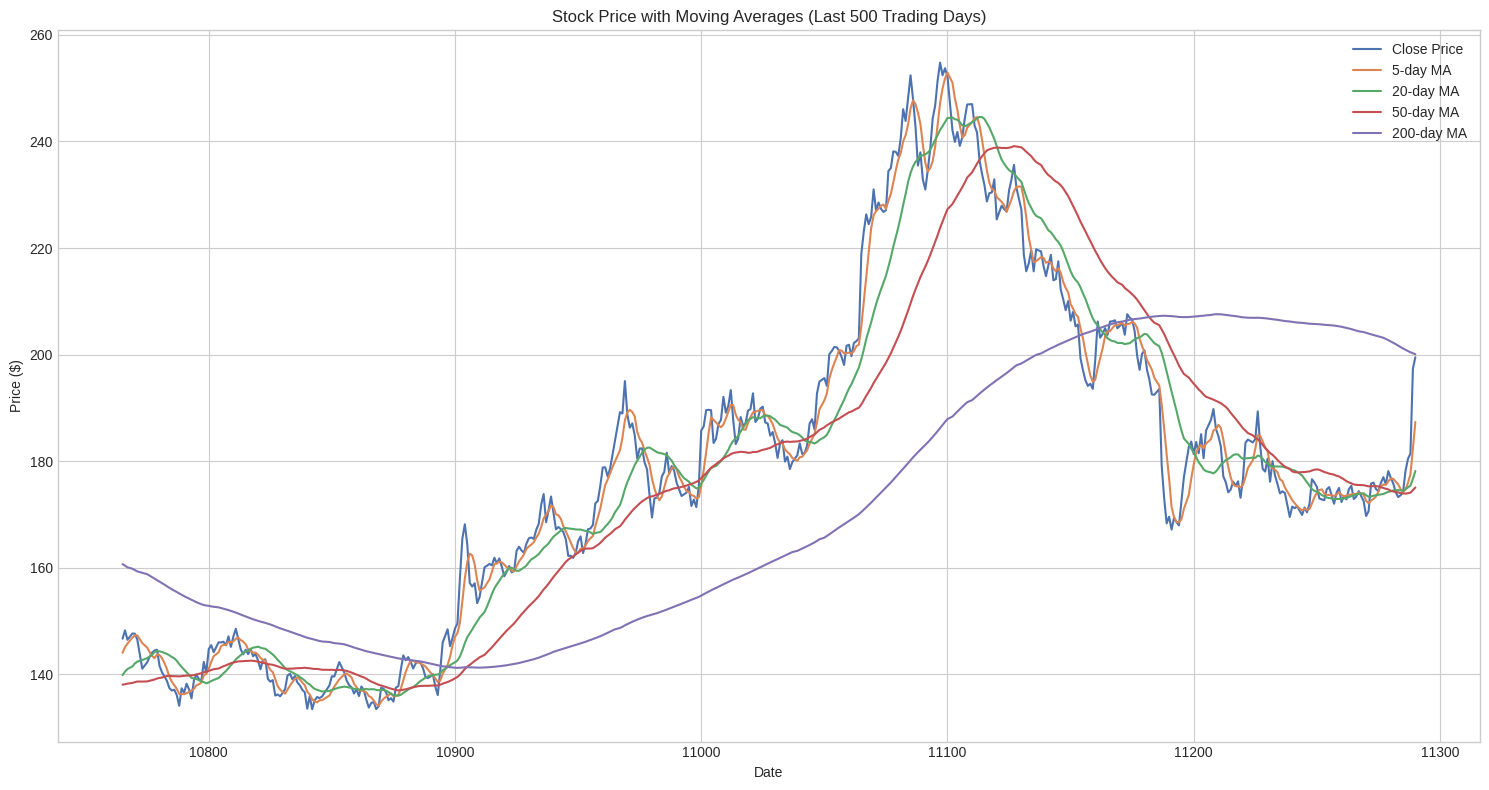

In [11]:
# Calculate moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

## 3. Price Trend Analysis

# Visualize price trends with moving averages
plt.figure(figsize=(15, 8))
plt.plot(df.index[-500:], df['Close'][-500:], label='Close Price')
plt.plot(df.index[-500:], df['MA5'][-500:], label='5-day MA', linewidth=1.5)
plt.plot(df.index[-500:], df['MA20'][-500:], label='20-day MA', linewidth=1.5)
plt.plot(df.index[-500:], df['MA50'][-500:], label='50-day MA', linewidth=1.5)
plt.plot(df.index[-500:], df['MA200'][-500:], label='200-day MA', linewidth=1.5)
plt.title('Stock Price with Moving Averages (Last 500 Trading Days)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

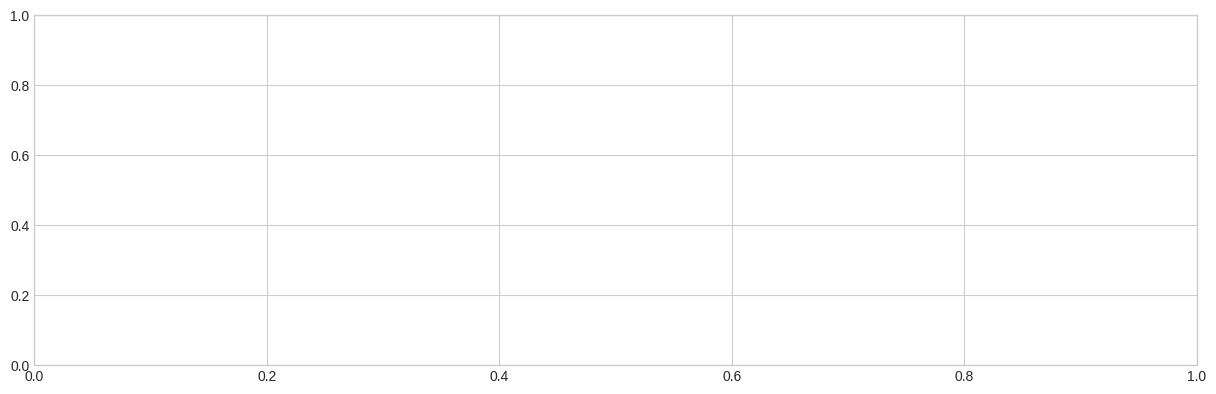

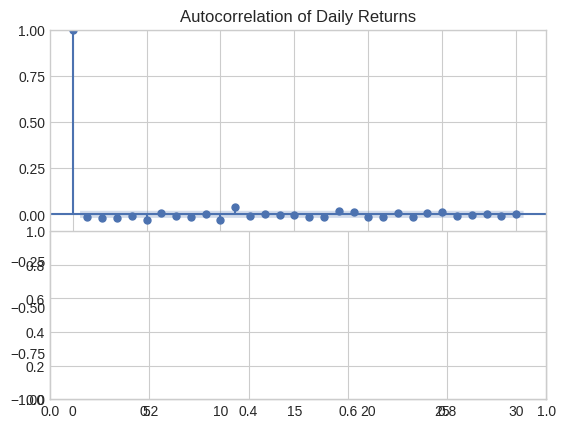

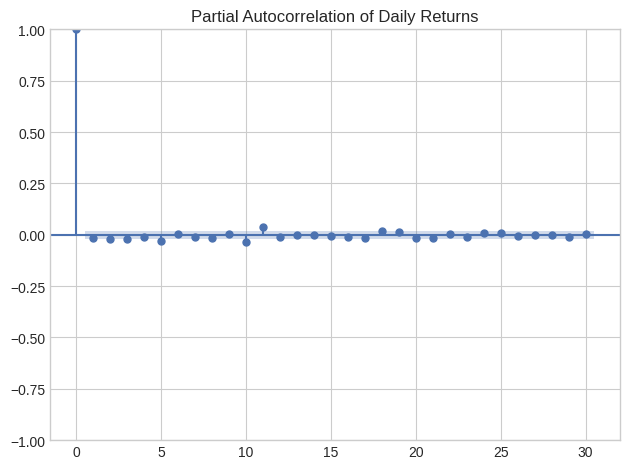

In [14]:
# Calculate daily returns
df['daily_return'] = df['Close'].pct_change()

## 9. Autocorrelation Analysis

# Calculate autocorrelations for closing price and returns
# Autocorrelation of returns can help identify if returns are predictable based on past returns
plt.figure(figsize=(15, 10))

plt.subplot(211)
plot_acf(df['daily_return'].dropna(), lags=30, alpha=0.05, title='Autocorrelation of Daily Returns')
plt.grid(True)

plt.subplot(212)
plot_pacf(df['daily_return'].dropna(), lags=30, alpha=0.05, title='Partial Autocorrelation of Daily Returns')
plt.grid(True)

plt.tight_layout()
plt.show()

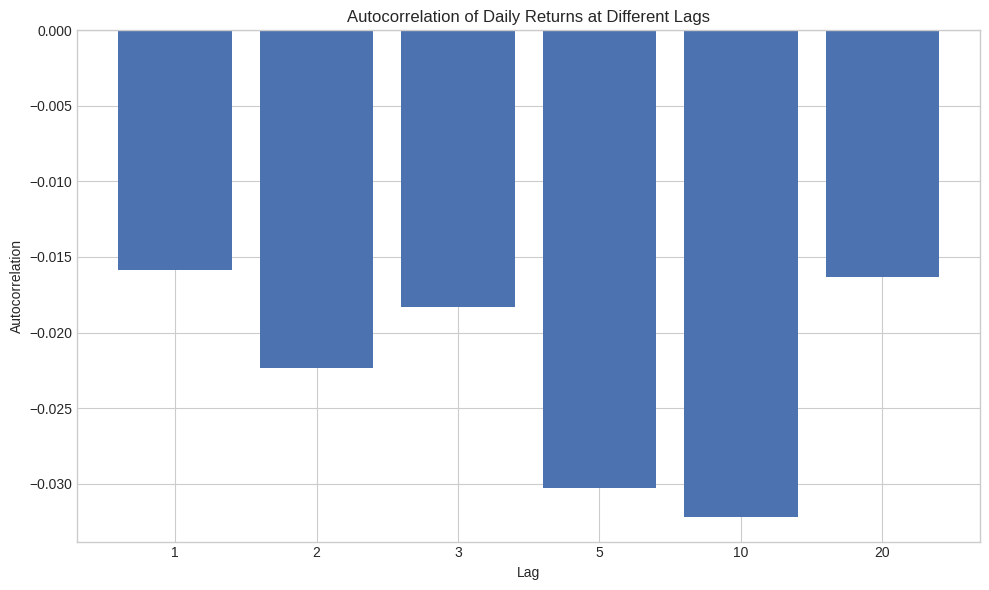

In [15]:
# Calculate autocorrelation for different lags
lags = [1, 2, 3, 5, 10, 20]
acf_values = []

for lag in lags:
    acf_values.append(df['daily_return'].autocorr(lag=lag))

plt.figure(figsize=(10, 6))
plt.bar(range(len(lags)), acf_values)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(range(len(lags)), lags)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Daily Returns at Different Lags')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

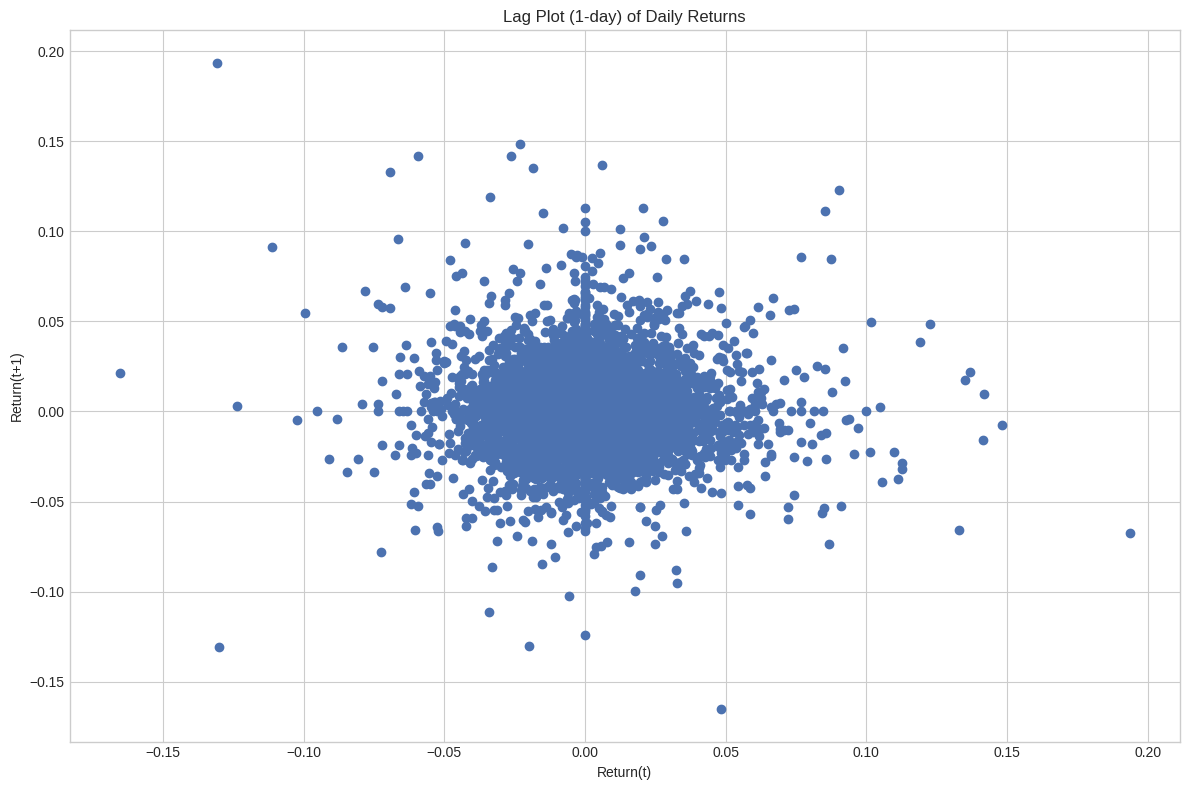

In [16]:
# Lag plot to visualize relationship between current and lagged returns
plt.figure(figsize=(12, 8))
pd.plotting.lag_plot(df['daily_return'].dropna(), lag=1)
plt.title('Lag Plot (1-day) of Daily Returns')
plt.xlabel('Return(t)')
plt.ylabel('Return(t+1)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Check for serial correlation in returns using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(df['daily_return'].dropna())
print(f"\nDurbin-Watson statistic for daily returns: {dw_stat:.4f}")
print("Note: Value close to 2 suggests no serial correlation, significantly different suggests presence of autocorrelation")


Durbin-Watson statistic for daily returns: 2.0299
Note: Value close to 2 suggests no serial correlation, significantly different suggests presence of autocorrelation


In [18]:
# 10. Risk Analysis

# Calculate rolling beta against market (we'll use the most recent 5 years)
# Note: Since we don't have market data, this is illustrative. In practice you would use S&P 500 or other benchmark.
# For demonstration, we'll calculate beta assuming this stock is part of a portfolio with the following synthetic market return

# Create synthetic market data for illustration (5% annual return with 15% volatility)
np.random.seed(42)  # For reproducibility
recent_data = df.iloc[-1260:].copy()  # ~5 years of daily data
recent_data['market_return'] = np.random.normal(0.05/252, 0.15/np.sqrt(252), len(recent_data))


In [19]:
# Calculate rolling beta (60-day window)
def calculate_beta(stock_returns, market_returns, window=60):
    # Calculate covariance between stock and market returns
    rolling_cov = stock_returns.rolling(window=window).cov(market_returns)
    # Calculate market variance
    rolling_var = market_returns.rolling(window=window).var()
    # Calculate beta
    beta = rolling_cov / rolling_var
    return beta

recent_data['beta'] = calculate_beta(recent_data['daily_return'], recent_data['market_return'])

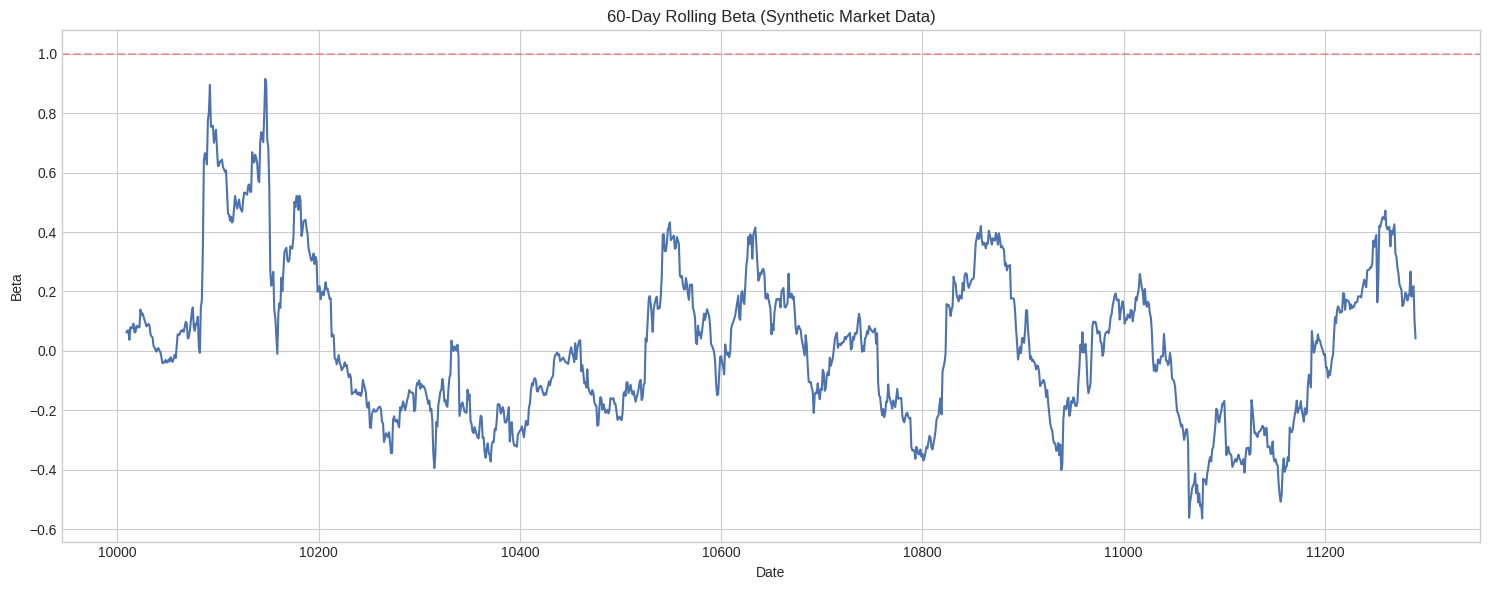

In [20]:
# Plot rolling beta
plt.figure(figsize=(15, 6))
plt.plot(recent_data.index, recent_data['beta'])
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
plt.title('60-Day Rolling Beta (Synthetic Market Data)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.grid(True)
plt.tight_layout()
plt.show()


Maximum historical drawdown: -61.19%


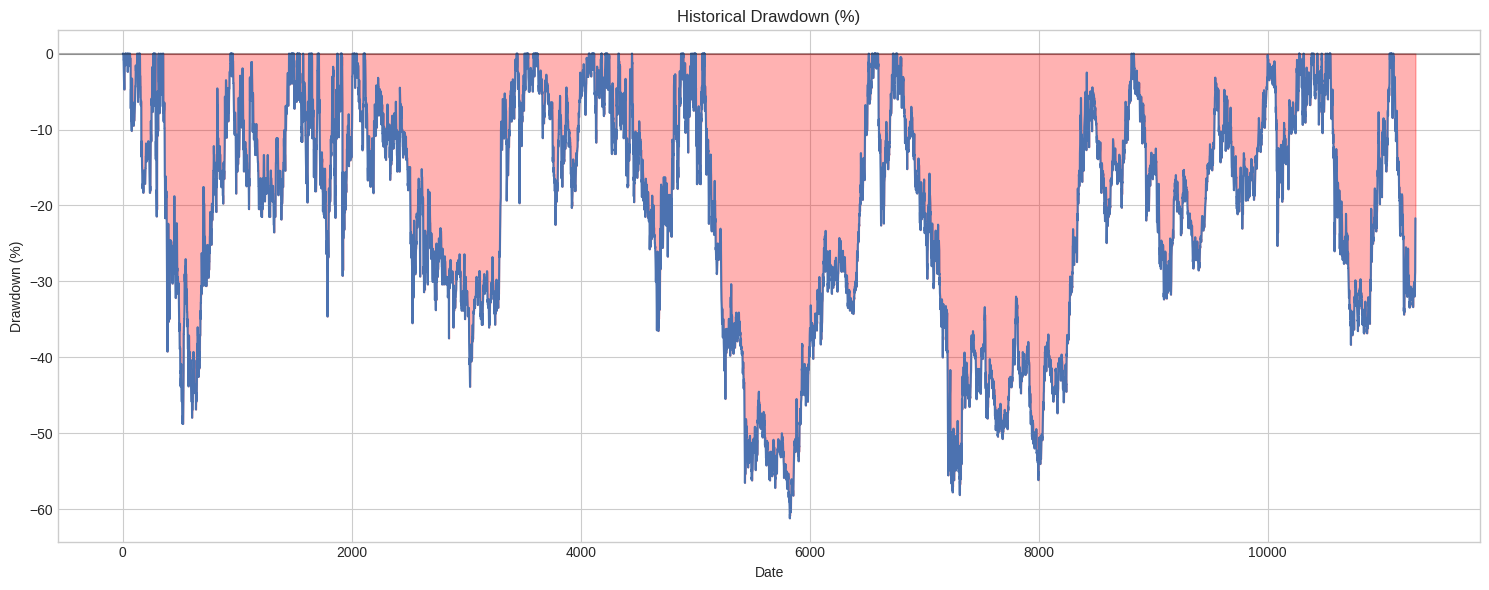

In [21]:
# Calculate maximum drawdown
def calculate_max_drawdown(prices):
    # Calculate cumulative maximum
    cummax = prices.cummax()
    # Calculate drawdown
    drawdown = (prices - cummax) / cummax
    # Find maximum drawdown
    max_drawdown = drawdown.min()
    return max_drawdown * 100  # Convert to percentage

max_dd = calculate_max_drawdown(df['Close'])
print(f"Maximum historical drawdown: {max_dd:.2f}%")

# Plot drawdown over time
df['drawdown'] = (df['Close'] / df['Close'].cummax() - 1) * 100

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['drawdown'])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(df.index, df['drawdown'], 0, color='red', alpha=0.3)
plt.title('Historical Drawdown (%)')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Calculate Sharpe ratio (assuming risk-free rate of 2%)
risk_free_rate = 0.02 / 252  # Daily risk-free rate
df['excess_return'] = df['daily_return'] - risk_free_rate
sharpe_ratio = (df['excess_return'].mean() / df['excess_return'].std()) * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.4f}")

Annualized Sharpe Ratio: 0.4112


In [23]:
# Calculate Sortino ratio (penalizes only downside volatility)
negative_returns = df['excess_return'][df['excess_return'] < 0]
sortino_ratio = (df['excess_return'].mean() / negative_returns.std()) * np.sqrt(252)
print(f"Annualized Sortino Ratio: {sortino_ratio:.4f}")

Annualized Sortino Ratio: 0.6181


In [25]:
# Creating placeholder columns for the missing features. Update logic as needed
# Momentum (5 and 20 days)
df['momentum_5d'] = df['Close'].pct_change(periods=5)  # 5-day momentum
df['momentum_20d'] = df['Close'].pct_change(periods=20)  # 20-day momentum

# Rate of Change (5 and 20 days)
df['roc_5d'] = df['Close'].pct_change(periods=5) * 100  # 5-day ROC
df['roc_20d'] = df['Close'].pct_change(periods=20) * 100  # 20-day ROC

# Volatility (using standard deviation of daily returns over a window)
df['volatility'] = df['daily_return'].rolling(window=20).std()  # 20-day volatility

# Moving Average Crossovers (1 if MA5 crosses above MA20, -1 if below, 0 otherwise)
df['ma_5_20_crossover'] = np.where(df['MA5'] > df['MA20'], 1, np.where(df['MA5'] < df['MA20'], -1, 0))
df['ma_20_50_crossover'] = np.where(df['MA20'] > df['MA50'], 1, np.where(df['MA20'] < df['MA50'], -1, 0))

# Relative Strength Index (RSI) - placeholder for now
df['RSI'] = 50  # You would need to implement actual RSI calculation

# Volume Pressure
df['volume_pressure'] = (df['Close'] - df['Open']) * df['Volume']

# Gap Percentage
df['gap_percent'] = ((df['Open'] - df['Close'].shift(1)) / df['Close'].shift(1)) * 100

# Average True Range (ATR) - placeholder
df['atr'] = 1  # You would need to implement actual ATR calculation

# Future 5-day return
df['future_5d_return'] = df['Close'].pct_change(periods=-5) # Calculate future 5-day return



# Create a dataframe of features for prediction (dropping NaN values)
prediction_features = df[
    ['daily_return', 'momentum_5d', 'momentum_20d', 'roc_5d', 'roc_20d',
     'volatility', 'ma_5_20_crossover', 'ma_20_50_crossover', 'RSI',
     'volume_pressure', 'gap_percent', 'atr', 'future_5d_return']
].dropna()

In [26]:
# Normalize features for comparing importance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(prediction_features.drop('future_5d_return', axis=1))
scaled_features_df = pd.DataFrame(
    scaled_features,
    columns=prediction_features.drop('future_5d_return', axis=1).columns,
    index=prediction_features.index
)

In [27]:
scaled_features_df['future_5d_return'] = prediction_features['future_5d_return']


Feature Importance for 5-day Future Return Prediction:
               Feature  Importance
5           volatility    0.197648
9      volume_pressure    0.162232
0         daily_return    0.135862
4              roc_20d    0.104826
2         momentum_20d    0.104688
3               roc_5d    0.091991
1          momentum_5d    0.089738
10         gap_percent    0.084456
7   ma_20_50_crossover    0.017727
6    ma_5_20_crossover    0.010833
8                  RSI    0.000000
11                 atr    0.000000


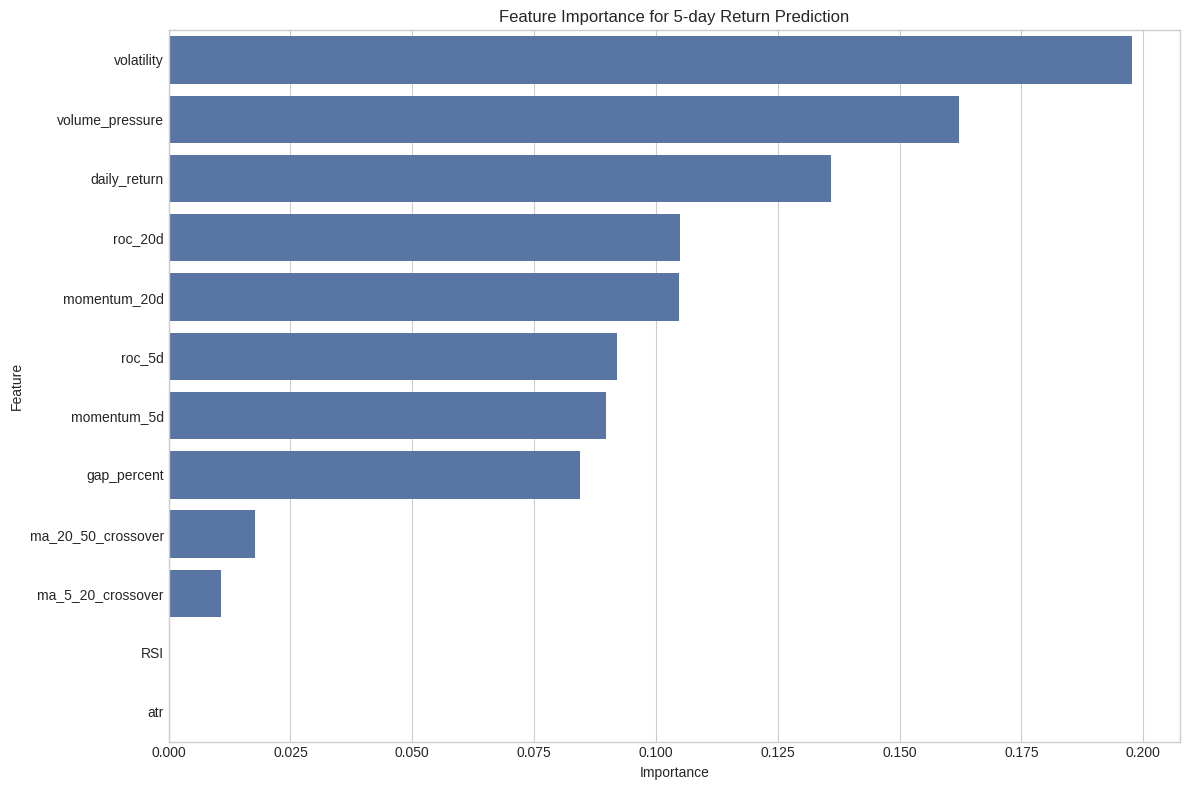

In [28]:
# Calculate feature importance using a simple Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = scaled_features_df.drop('future_5d_return', axis=1)
y = scaled_features_df['future_5d_return']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Train a simple model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance for 5-day Future Return Prediction:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for 5-day Return Prediction')
plt.xlabel('Importance')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [32]:
## 12. Conclusion and Key Insights

print("\n=== Summary of Exploratory Data Analysis ===")
# Convert the index to datetime if it's not already
df.index = pd.to_datetime(df.index)
print(f"1. Dataset covers {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}, with {len(df)} trading days.")
print(f"2. Price range: ${df['Close'].min():.2f} to ${df['Close'].max():.2f}, with significant growth over time.")
print(f"3. Average daily return: {df['daily_return'].mean():.4f}% with standard deviation of {df['daily_return'].std():.4f}%.")
print(f"4. Maximum historical drawdown: {max_dd:.2f}%.")
# Calculate volume_return_corr before printing it
volume_return_corr = df['Volume'].corr(df['daily_return'].abs()) # Calculating the correlation
print(f"5. Volume shows {volume_return_corr:.4f} correlation with absolute price changes.")


=== Summary of Exploratory Data Analysis ===
1. Dataset covers 1970-01-01 to 1970-01-01, with 10525 trading days.
2. Price range: $3.24 to $254.77, with significant growth over time.
3. Average daily return: 0.0006% with standard deviation of 0.0187%.
4. Maximum historical drawdown: -61.19%.
5. Volume shows 0.1457 correlation with absolute price changes.


In [33]:
# prompt: output csv file with the changes done to the original csv file

# Assuming 'df' is your DataFrame with the added columns and calculations

# Specify the output file name
output_file = 'modified_stock_data.csv'

# Save the DataFrame to a CSV file
df.to_csv(output_file, index=False)  # index=False prevents writing the index to the file

print(f"Modified data saved to '{output_file}'")


Modified data saved to 'modified_stock_data.csv'
